In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
import os
from tqdm import tqdm, tnrange, tqdm_notebook
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import sys
import scipy.ndimage

In [6]:
# import nibabel as nib

In [7]:
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *

In [9]:
import pandas as pd

## Define paths

In [10]:
# UPDATE ACCORDING TO SYSTEM PATH
path_str = '/home/ubuntu/sfr-challenge/lungs/dataset'

In [11]:
path = Path(path_str)

In [12]:
path_seg = path/'seg_3d'

In [13]:
path_p = path/'Pathologiques'

In [14]:
path_n = path/'Normaux'

In [15]:
path_train = path_str + '/train'

In [16]:
test_path = path_str + '/Pathologiques/N7Q0jai/N7Q0jai'

## Define fixed random seed

In [17]:
np.random.seed(42)

## Test section ==>

In [18]:
# cell to run the experiments

## <== End of test section

## Train network

In [19]:
bs = 32
valid_split = 0.15

In [20]:
data = ImageDataBunch.from_folder(path/'train', ds_tfms=get_transforms(), size=224, bs=bs, valid_pct=valid_split)

In [21]:
pd.value_counts(data.train_dl.y.items.flatten(), sort=False)

0    4885
1    1325
dtype: int64

In [22]:
pd.value_counts(data.valid_dl.y.items.flatten(), sort=False)

0    849
1    246
dtype: int64

In [23]:
data.classes

['0', '1']

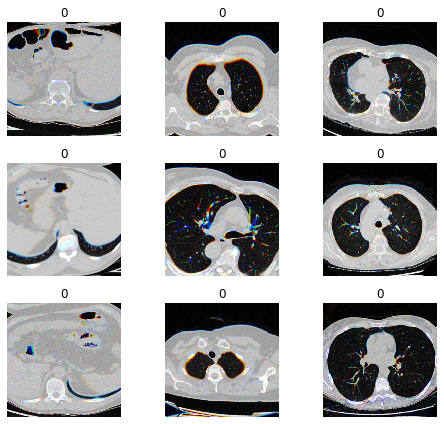

In [24]:
data.show_batch(rows=3, figsize=(7,6))

In [25]:
learner = cnn_learner(data, models.vgg16_bn, metrics=[error_rate, AUROC()], callback_fns=[ShowGraph], pretrained=True).to_fp16()
#learner = cnn_learner(data, models.resnet18, metrics=[error_rate, f1_score(), AUROC()], callback_fns=[ShowGraph], pretrained=True)

In [26]:
#verify_images(path/'train'/'0')

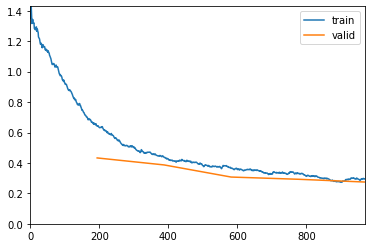

In [27]:
learner.fit_one_cycle(5)

In [28]:
learner.save('stage-1')

In [29]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

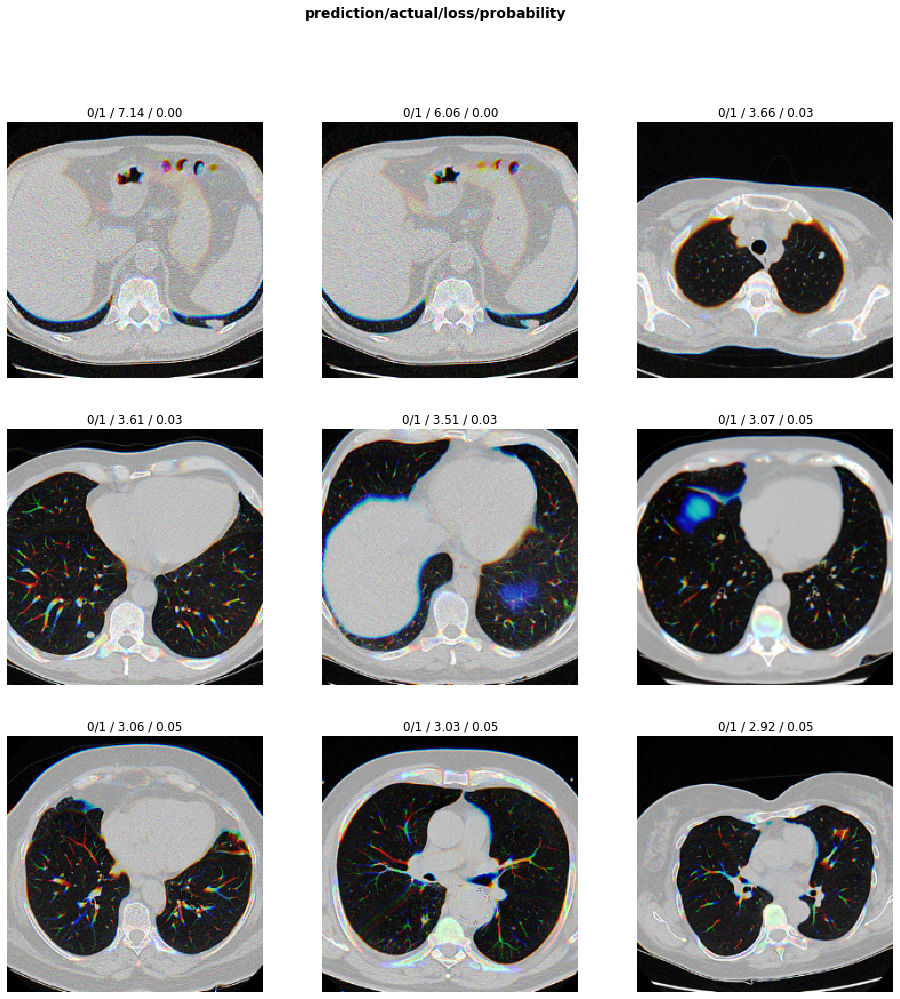

In [30]:
interp.plot_top_losses(9, figsize=(16,16))

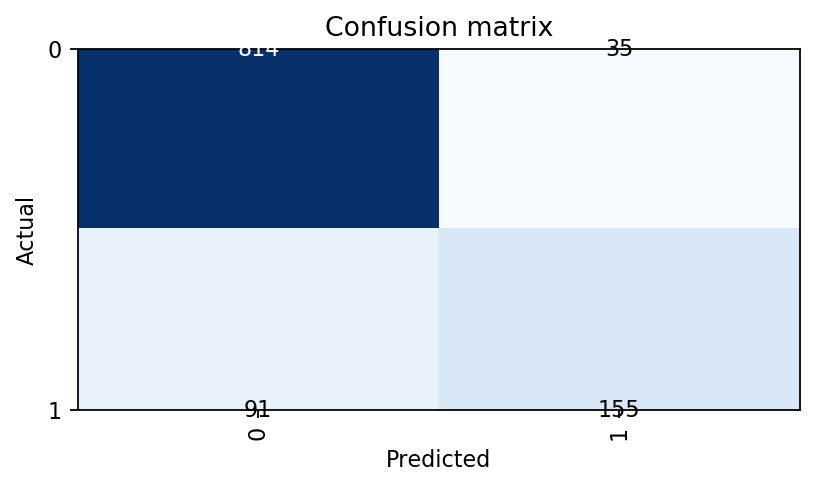

In [31]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=160)

In [32]:
interp.most_confused(min_val=2)

[('1', '0', 91), ('0', '1', 35)]

## Unfreeze all model layer and tune learning rate

In [35]:
learner.unfreeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


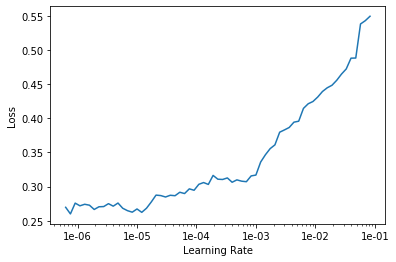

In [36]:
learner.recorder.plot()

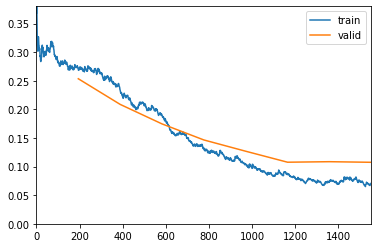

In [37]:
learner.fit_one_cycle(8, max_lr=slice(1e-5, 1e-4))

In [38]:
learner.save('stage-2-8epc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


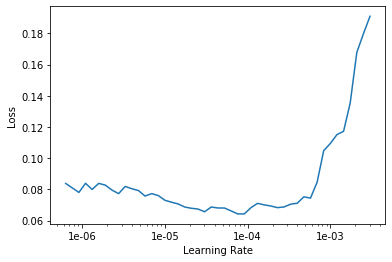

In [39]:
learner.lr_find()
learner.recorder.plot()

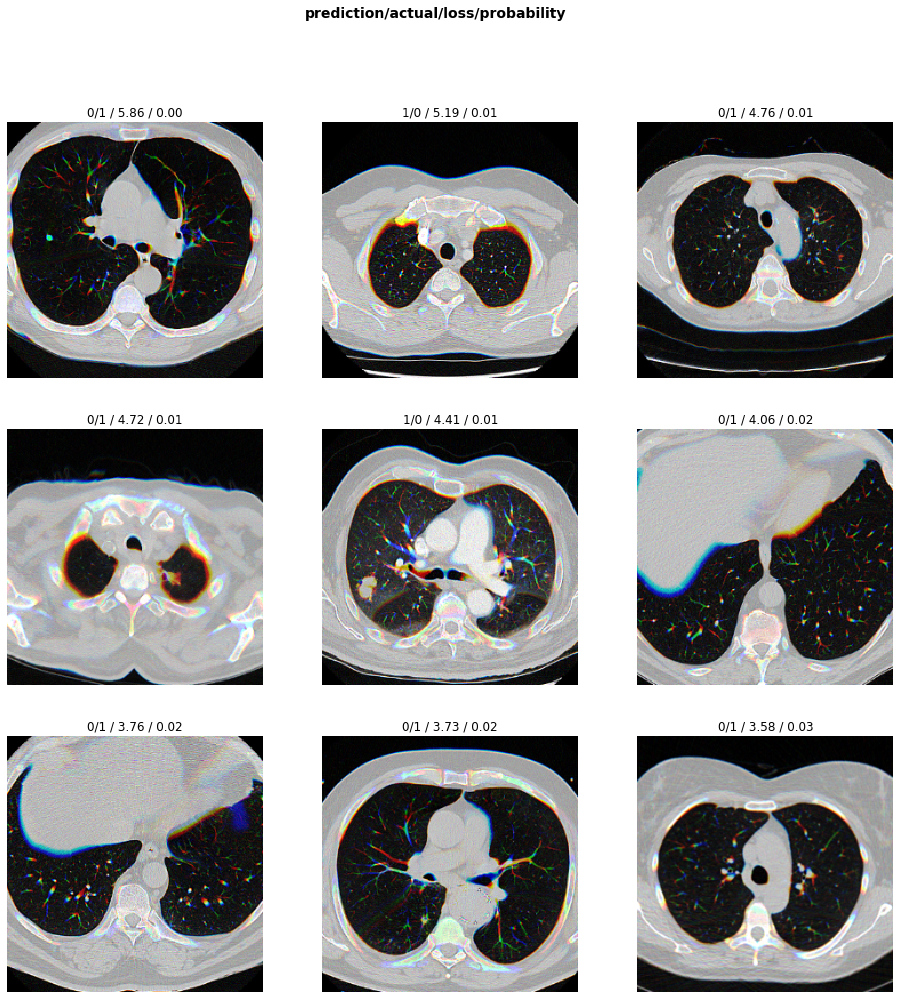

In [40]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
# plot
interp.plot_top_losses(9, figsize=(16,16))

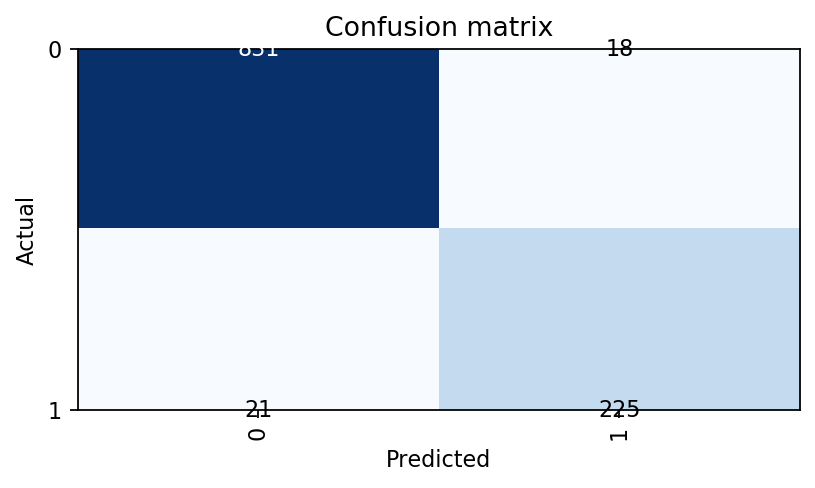

In [41]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=160)

Add x4 epochs using lower learning rate

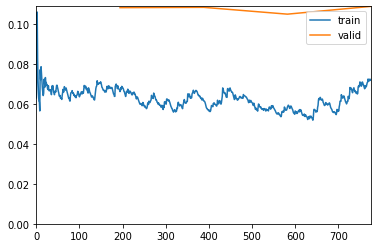

In [42]:
learner.unfreeze()
learner.fit_one_cycle(4, max_lr=3e-6)

In [43]:
learner.save('stage-2-12epc')

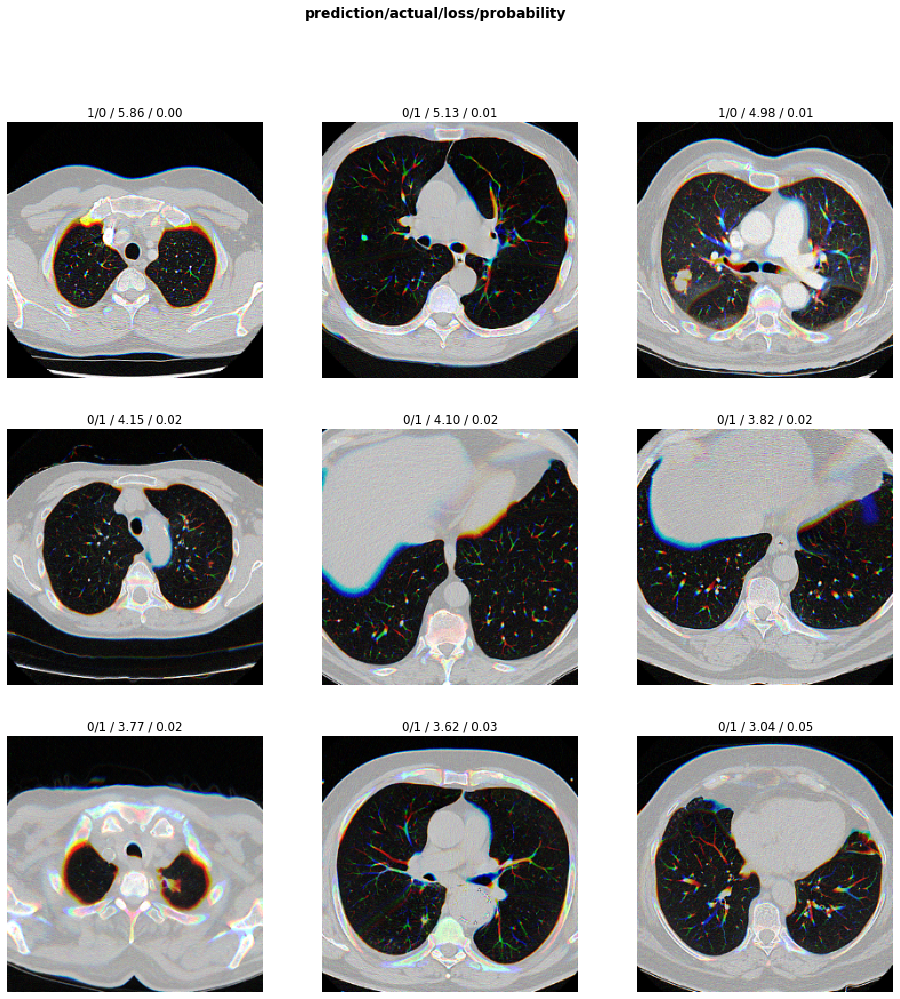

In [45]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
# plot
interp.plot_top_losses(9, figsize=(16,16))

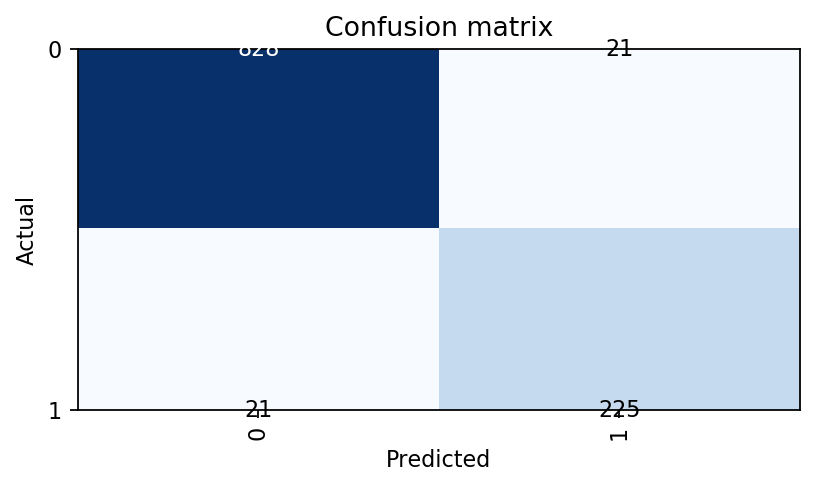

In [46]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=160)

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(4, max_lr=1e-6)

In [ ]:
learner.save('stage-2-18epc')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
# plot
interp.plot_top_losses(9, figsize=(16,16))

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=160)

In [ ]:
learner.load('stage-2-14epc')

In [47]:
learner.load('stage-2-8epc')

Learner(data=ImageDataBunch;

Train: LabelList (6210 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /home/ubuntu/sfr-challenge/lungs/dataset/train;

Valid: LabelList (1095 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,0,0
Path: /home/ubuntu/sfr-challenge/lungs/dataset/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [48]:
learner.export('final-vgg16-12epc-1013-1130')